## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Господинов Георгий

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
n_epoch = 50

In [3]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
images_train, labels_train = next(iter(train_loader))

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

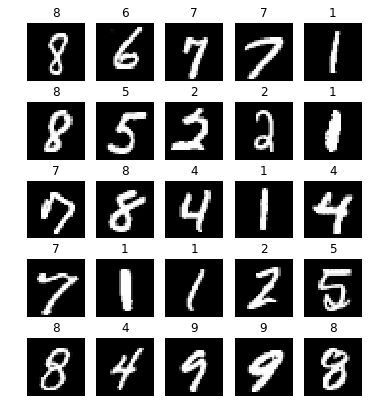

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [7]:
def Normal_init_layer(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)
    
def Xavier_init_layer(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    a = (6.0 / (weight.shape[0] + weight.shape[1])) ** 0.5
    weight.uniform_(-a, a)
    
def He_init_layer(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=(2.0/weight.shape[1]) ** 0.5)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print('forward std: {std}'.format(std=std))

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().data[0]
    print('backward std: {std}'.format(std=std))

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
Normal_init_layer(layer) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
def new_linear_layer(input_size, output_size, init_layer):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer)
    return layer

In [9]:
##### YOUR CODE HERE #####
def check_std(init_layer):
    layers = []
    layers.append(new_linear_layer(28 * 28, 500, init_layer))
    layers.append(nn.Tanh())
    for i in range(10):
        layers.append(new_linear_layer(500, 500, init_layer))
        layers.append(nn.Tanh())
    layers.append(new_linear_layer(500, 10, init_layer))
    layers.append(nn.LogSoftmax())
    network = nn.Sequential(*layers)

    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [10]:
check_std(Normal_init_layer)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


forward std: 0.9885128736495972
forward std: 0.9850830435752869
forward std: 0.9816234111785889
forward std: 0.9815650582313538
forward std: 0.9816405773162842
forward std: 0.9808372855186462
forward std: 0.9816350936889648
forward std: 0.9815768003463745
forward std: 0.9815768599510193
forward std: 0.9815824627876282
forward std: 0.9816121459007263
forward std: 0.981548011302948


C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


backward std: 0.0040833111852407455
backward std: 0.0020416846964508295
backward std: 0.007017284631729126
backward std: 0.023527931421995163
backward std: 0.08227919042110443
backward std: 0.28508949279785156
backward std: 0.9777823686599731
backward std: 3.455099105834961
backward std: 12.391048431396484
backward std: 40.18525314331055
backward std: 137.56314086914062
backward std: 414.30938720703125


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [11]:
##### YOUR CODE HERE #####
check_std(Xavier_init_layer)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


forward std: 0.9885128736495972
forward std: 0.6465194821357727
forward std: 0.4920884668827057
forward std: 0.4137222468852997
forward std: 0.36316677927970886
forward std: 0.32515624165534973
forward std: 0.29829078912734985
forward std: 0.27548864483833313
forward std: 0.2630411982536316
forward std: 0.24570007622241974
forward std: 0.22901779413223267
forward std: 0.21909953653812408


C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


backward std: 0.0030220013577491045
backward std: 0.00057684734929353
backward std: 0.0005410959129221737
backward std: 0.0005070367478765547
backward std: 0.00047007258399389684
backward std: 0.0004370850801933557
backward std: 0.00040025549242272973
backward std: 0.00035134964855387807
backward std: 0.00030564545886591077
backward std: 0.00025927938986569643
backward std: 0.00020697595027741045
backward std: 0.00013896098244003952


In [12]:
check_std(He_init_layer)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


forward std: 0.9885128736495972
forward std: 0.7105677127838135
forward std: 0.6276394724845886
forward std: 0.5877037644386292
forward std: 0.572084367275238
forward std: 0.5620133876800537
forward std: 0.5565848350524902
forward std: 0.5547536611557007
forward std: 0.5534541606903076
forward std: 0.5595139861106873
forward std: 0.556808352470398
forward std: 0.5592719912528992


C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


backward std: 0.00311221438460052
backward std: 0.0004625355650205165
backward std: 0.0004739775322377682
backward std: 0.000494863314088434
backward std: 0.0005270480760373175
backward std: 0.0005479134852066636
backward std: 0.0005734257865697145
backward std: 0.0006014087703078985
backward std: 0.0006206839461810887
backward std: 0.0006248389254324138
backward std: 0.0006013527163304389
backward std: 0.0005178701831027865


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])


Epoch 49... (Train/Test) NLL: 0.005/0.205	Accuracy: 0.998/0.976

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


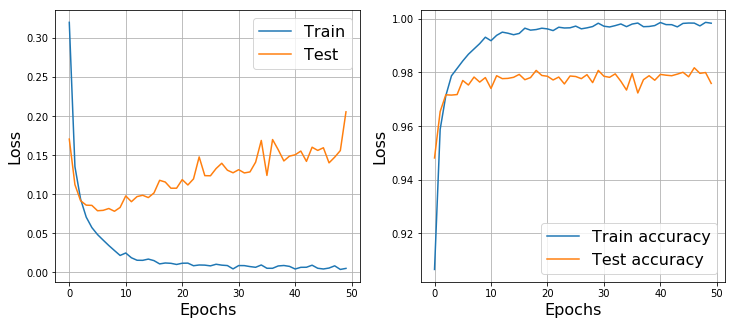

In [13]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

loss, ac = train_utils.train(network, train_loader, test_loader, n_epoch, 0.001, ravel_init=True)

C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])


Epoch 49... (Train/Test) NLL: 0.150/0.101	Accuracy: 0.955/0.971

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


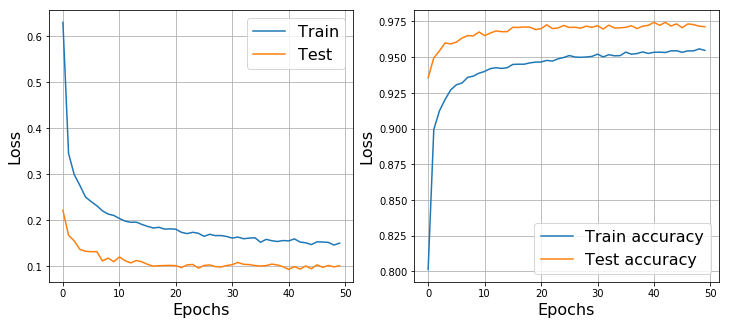

In [14]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

DO_loss, DO_ac  = train_utils.train(network, train_loader, test_loader, n_epoch, 0.001, ravel_init=True)

In [15]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+(1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])


Epoch 49... (Train/Test) NLL: 0.078/0.065	Accuracy: 0.975/0.981

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


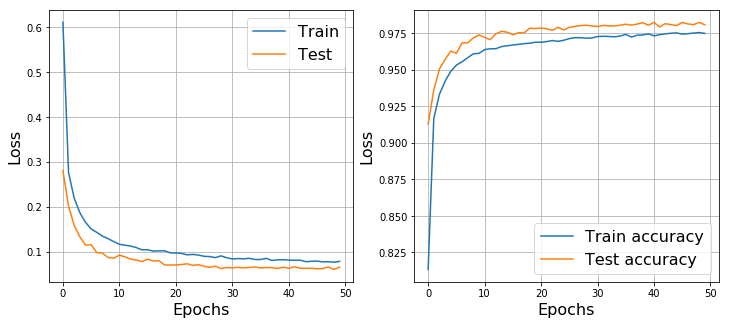

In [16]:
network = nn.Sequential(DropConnect(784, 100, p=0.5),
                        nn.ReLU(),
                        DropConnect(100, 100, p=0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

DC_loss, DC_ac = train_utils.train(network, train_loader, test_loader, n_epoch, 0.001, ravel_init=True)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

<i> 2.3 Сделайте выводы по третьей части </i>

In [17]:
def plotter(ys, labels, xlabel, ylabel, grid=True, fontsize=14, title=''):
    for i in range(len(ys)):
        plt.plot(ys[i], label=labels[i])
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    if grid:
        plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

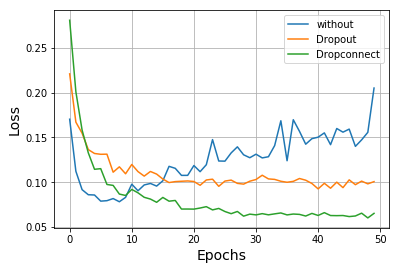

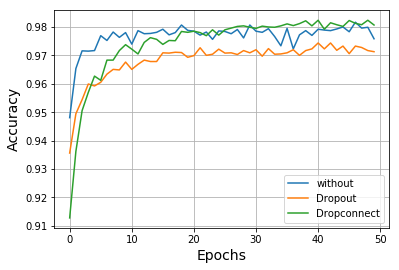

In [18]:
plotter([loss, DO_loss,  DC_loss], labels=['without', 'Dropout', 'Dropconnect'], xlabel='Epochs', ylabel='Loss')
plotter([ac, DO_ac,  DC_ac], labels=['without', 'Dropout', 'Dropconnect'], xlabel='Epochs', ylabel='Accuracy')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [19]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean()) / x.std()
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])


Epoch 49... (Train/Test) NLL: 0.005/0.156	Accuracy: 0.998/0.981

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


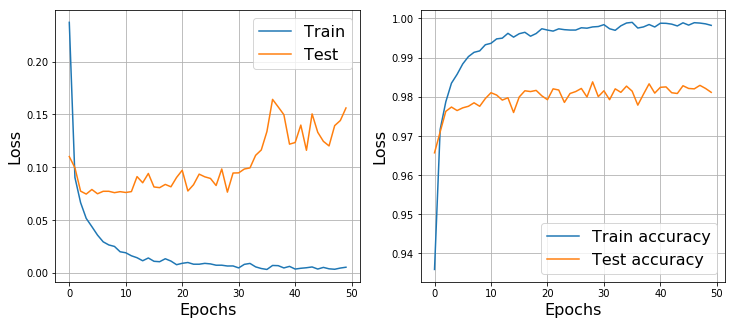

In [20]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.BatchNorm1d(num_features=200),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.BatchNorm1d(num_features=200),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

BN_loss, BN_ac = train_utils.train(network, train_loader, test_loader, n_epoch, 0.001, ravel_init=True)

C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])


Epoch 49... (Train/Test) NLL: 0.000/0.083	Accuracy: 1.000/0.984

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


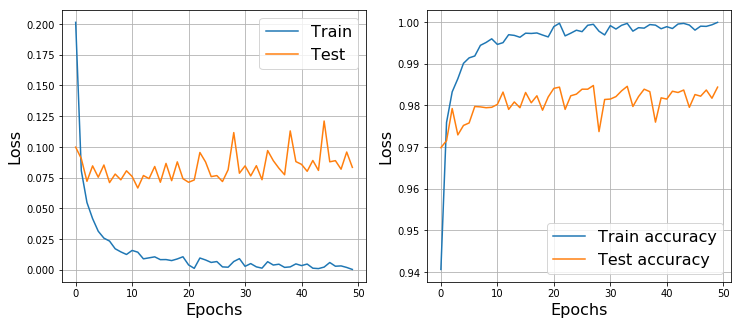

In [21]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        LayerNormalization(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        LayerNormalization(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

LN_loss, LN_ac = train_utils.train(network, train_loader, test_loader, n_epoch, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

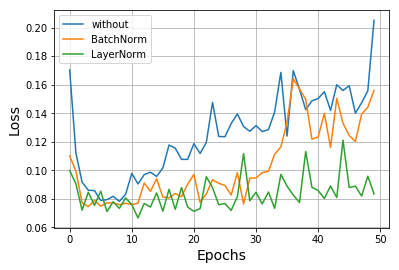

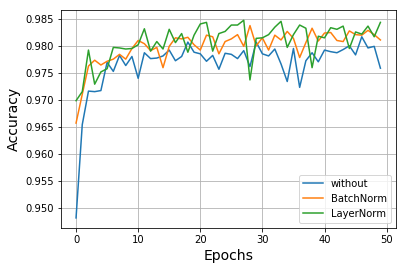

In [22]:
plotter([loss, BN_loss,  LN_loss], labels=['without', 'BatchNorm', 'LayerNorm'], xlabel='Epochs', ylabel='Loss')
plotter([ac, BN_ac,  LN_ac], labels=['without', 'BatchNorm', 'LayerNorm'], xlabel='Epochs', ylabel='Accuracy')

### BatchNorm + Dropconnect

C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])
C:\Users\Георгий\Desktop\seminar_05\train_utils.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])


Epoch 49... (Train/Test) NLL: 0.069/0.063	Accuracy: 0.977/0.981

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


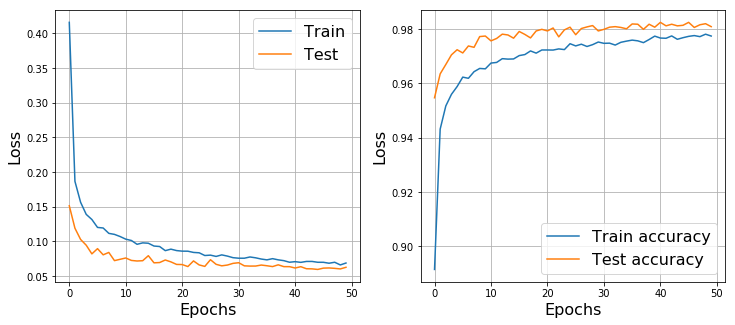

In [23]:
network = nn.Sequential(DropConnect(784, 100, p=0.5),
                        nn.ReLU(),
                        nn.BatchNorm1d(num_features=100),
                        DropConnect(100, 100, p=0.5),
                        nn.ReLU(),
                        nn.BatchNorm1d(num_features=100),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

final_loss, final_ac = train_utils.train(network, train_loader, test_loader, n_epoch, 0.001, ravel_init=True)

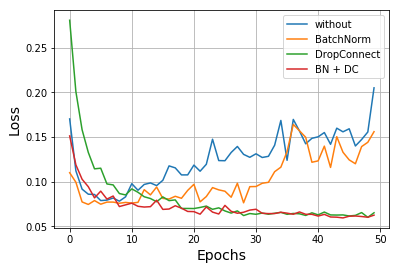

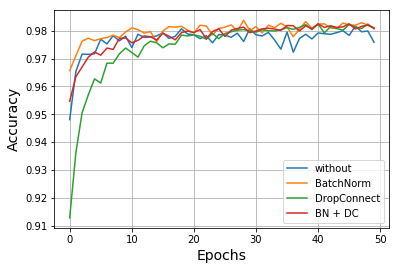

In [24]:
plotter([loss, BN_loss,  DC_loss, final_loss], labels=['without', 'BatchNorm', 'DropConnect', 'BN + DC'], xlabel='Epochs', ylabel='Loss')
plotter([ac, BN_ac,  DC_ac, final_ac], labels=['without', 'BatchNorm', 'DropConnect', 'BN + DC'], xlabel='Epochs', ylabel='Accuracy')

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: